## Time Series forecasting using ARIMA 
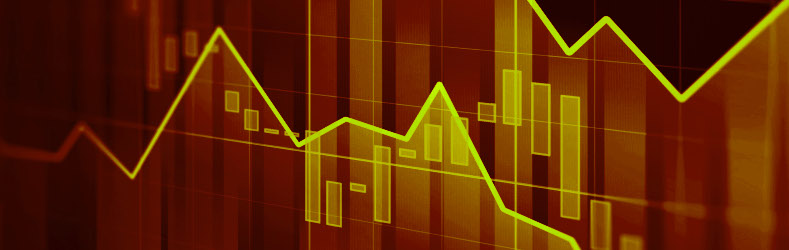



In [1]:
!pip install pmdarima

You should consider upgrading via the 'c:\users\4piho\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:

from sklearn.metrics import mean_squared_error
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators

## Data Preparation
Reading the market data of AAPL stock and preparing a training dataset and validation dataset.

In [3]:
key='DUQG7U14LK4C3BT2'
# key = '5Y3MCR5FPN0GYZGO'
apiKey = key
ticker = 'AAPL'

df_temp = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol='+ticker+'&apikey='+apiKey+'&outputsize=full&datatype=csv') 
ma5 = pd.read_csv('https://www.alphavantage.co/query?function=EMA&symbol='+ticker+'&interval=daily&time_period=5&series_type=close&apikey='+apiKey+'&datatype=csv')
ma30 = pd.read_csv('https://www.alphavantage.co/query?function=EMA&symbol='+ticker+'&interval=daily&time_period=30&series_type=close&apikey='+apiKey+'&datatype=csv')
ma180 = pd.read_csv('https://www.alphavantage.co/query?function=EMA&symbol='+ticker+'&interval=daily&time_period=180&series_type=close&apikey='+apiKey+'&datatype=csv')
atr = pd.read_csv('https://www.alphavantage.co/query?function=ATR&symbol='+ticker+'&interval=daily&time_period=14&apikey='+apiKey+'&datatype=csv&outputsize=full')


ma5 = ma5.truncate( after = 2564)
ma30 = ma30.truncate( after = 2564)
ma180= ma180.truncate( after = 2564)
df_temp = df_temp.truncate( after = 2564)
atr = atr.truncate(after = 2564)
df = df_temp.copy()
df['atr'] = atr['ATR']
df['ma5'] = ma5['EMA']
df['ma30'] = ma30['EMA']
df['ma180'] = ma180['EMA']
#now df has 10 columns with diff daily feature data 

In [5]:
df.isnull().values.any()


False

In [6]:
import time
# time.sleep(60)
key = '5Y3MCR5FPN0GYZGO'
apiKey= key
rsi = pd.read_csv('https://www.alphavantage.co/query?function=RSI&symbol='+ticker+'&interval=daily&time_period=14&series_type=open&apikey='+apiKey+'&datatype=csv')
rsi['time'][0] = rsi['time'][0].split()[0]
obv = pd.read_csv('https://www.alphavantage.co/query?function=OBV&symbol='+ticker+'&interval=daily&apikey='+apiKey+'&datatype=csv')
obv['time'][0] = obv['time'][0].split()[0]
macd = pd.read_csv('https://www.alphavantage.co/query?function=MACD&symbol='+ticker+'&interval=daily&series_type=open&apikey='+apiKey+'&datatype=csv')
url = 'https://www.alphavantage.co/query?function=EARNINGS&symbol='+ticker+'&apikey='+apiKey


<ipython-input-6-29a3a4ffb087>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rsi['time'][0] = rsi['time'][0].split()[0]
<ipython-input-6-29a3a4ffb087>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obv['time'][0] = obv['time'][0].split()[0]


In [7]:
import requests
r = requests.get(url)
data = r.json()
eps_list = data['quarterlyEarnings']
eps = pd.DataFrame(columns=['date', 'eps'])
for i in range(len(eps_list)):
    eps.loc[i] = [eps_list[i]['reportedDate'],eps_list[i]['reportedEPS']]
rsi = rsi.truncate(after = 2564)
obv = obv.truncate(after = 2564)
macd = macd.truncate(after = 2564)
eps = eps.truncate(after = 2564)
df['rsi'] = rsi['RSI']
df['obv'] =  obv['OBV']
df['macd'] = macd['MACD_Hist']


In [ ]:
df.set_index('timestamp',drop = True, inplace = True)
eps.set_index('date',drop = True, inplace = True)
df['eps'] = eps['eps']
df.reset_index(inplace =True)
eps.reset_index(inplace  = True)
row = 0

for i in range(len(df)):
    if(pd.isnull(df['eps'][i])):
        df['eps'][i] = eps['eps'][row]
    else:
        row = row+1
temp=pd.DataFrame()
temp['time']=df['timestamp']
temp['senti']=np.nan
temp['prev']=np.nan
index_eps=0
# print(eps['eps'][1])
for i in range(len(df)-1):
    temp['senti'][i]=0.99
    temp['prev'][i]=df['close'][i+1]
# df['eps']=temp['eps']
df['senti']=temp['senti']
df['prev']=temp['prev']
df = df[:-1]
    
#now df has 14 columns with diff daily feature data for the past 2 years


In [10]:
 df =df.iloc[::-1]

In [11]:
df.set_index("timestamp", drop=False, inplace=True)

In [12]:
df.head()

,timestamp,open,high,low,close,volume,atr,ma5,ma30,ma180,rsi,obv,macd,eps,senti,prev
timestamp,,,,,,,,,,,,,,,,
2011-04-27,2011-04-27,352.24,352.350,347.100,350.15,12721900,0.1999,10.6874,10.5194,9.7448,57.1604,9.193575e+10,0.0728,0.2275,0.99,350.42
2011-04-28,2011-04-28,346.19,349.750,345.520,346.75,12891400,0.1958,10.6741,10.5277,9.7548,52.1276,9.157479e+10,0.0592,0.2275,0.99,350.15
2011-04-29,2011-04-29,346.78,353.950,346.666,350.13,35940900,0.1978,10.6999,10.5421,9.7658,52.5662,9.258114e+10,0.0490,0.2275,0.99,346.75
2011-05-02,2011-05-02,349.74,350.469,345.500,346.28,15811200,0.1945,10.6777,10.5480,9.7754,54.8035,9.213843e+10,0.0459,0.2275,0.99,350.13
2011-05-03,2011-05-03,347.99,349.890,345.620,348.20,11191000,0.1900,10.6825,10.5573,9.7855,53.2057,9.245177e+10,0.0380,0.2275,0.99,346.28


Plotting the target variable **close** over time

<AxesSubplot:xlabel='timestamp'>

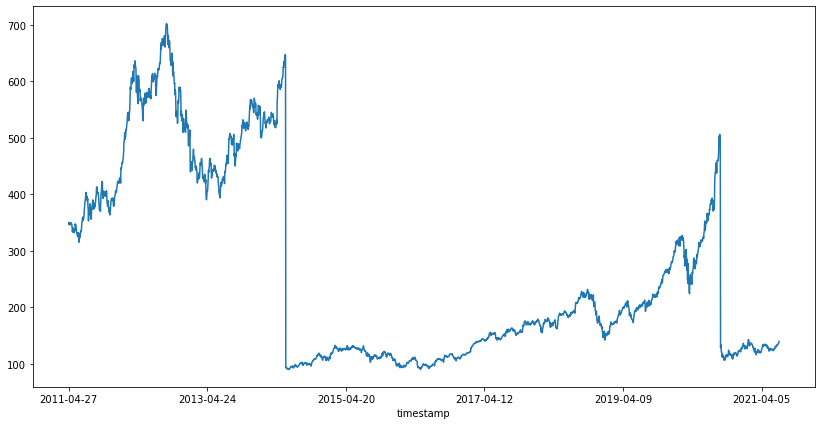

In [13]:
df.close.plot(figsize=(14, 7))

## Feature Engineering
Almost every time series problem will have some external features or some internal feature engineering to help the model.

Let's add some basic features like lag values of available numeric features that are widely used for time series problems. Since we need to predict the price of the stock for a day, we cannot use the feature values of the same day since they will be unavailable at actual inference time. We need to use statistics like mean, standard deviation of their lagged values.

We will use three sets of lagged values, one previous day, one looking back 7 days and another looking back 30 days as a proxy for last week and last month metrics.

In [14]:
df.reset_index(drop=True, inplace=True)
lag_features = ["high", "low", "volume", "atr","rsi","obv","macd",
                "prev"
               ]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("timestamp", drop=False, inplace=True)
df.head()

,timestamp,open,high,low,close,volume,atr,ma5,ma30,ma180,...,macd_mean_lag30,macd_std_lag3,macd_std_lag7,macd_std_lag30,prev_mean_lag3,prev_mean_lag7,prev_mean_lag30,prev_std_lag3,prev_std_lag7,prev_std_lag30
timestamp,,,,,,,,,,,,,,,,,,,,,
2011-04-27,2011-04-27,352.24,352.350,347.100,350.15,12721900,0.1999,10.6874,10.5194,9.7448,...,-0.000097,0.044121,0.081979,0.180998,264.822021,264.989502,265.964752,3.477123,5.700310,13.945580
2011-04-28,2011-04-28,346.19,349.750,345.520,346.75,12891400,0.1958,10.6741,10.5277,9.7548,...,0.072800,0.044121,0.081979,0.180998,350.420013,350.420013,350.420013,3.477123,5.700310,13.945580
2011-04-29,2011-04-29,346.78,353.950,346.666,350.13,35940900,0.1978,10.6999,10.5421,9.7658,...,0.066000,0.009617,0.009617,0.009617,350.285004,350.285004,350.285004,0.190919,0.190919,0.190919
2011-05-02,2011-05-02,349.74,350.469,345.500,346.28,15811200,0.1945,10.6777,10.5480,9.7754,...,0.060333,0.011940,0.011940,0.011940,349.106659,349.106659,349.106659,2.045393,2.045393,2.045393
2011-05-03,2011-05-03,347.99,349.890,345.620,348.20,11191000,0.1900,10.6825,10.5573,9.7855,...,0.056725,0.006959,0.012130,0.012130,349.010010,349.362488,349.362488,1.957243,1.746680,1.746680


For boosting models, it is very useful to add datetime features like hour, day, month, as applicable to provide the model information about the time component in the data. For time series models it is not explicitly required to pass this information but we could do so and we will in this notebook so that all models are compared on the exact same set of features.

In [15]:
df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%d")
df["month"] = df.timestamp.dt.month
df["week"] = df.timestamp.dt.week
df["day"] = df.timestamp.dt.day
df["day_of_week"] = df.timestamp.dt.dayofweek
df.head()

<ipython-input-15-0f034f215640>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week"] = df.timestamp.dt.week


,timestamp,open,high,low,close,volume,atr,ma5,ma30,ma180,...,prev_mean_lag3,prev_mean_lag7,prev_mean_lag30,prev_std_lag3,prev_std_lag7,prev_std_lag30,month,week,day,day_of_week
timestamp,,,,,,,,,,,,,,,,,,,,,
2011-04-27,2011-04-27,352.24,352.350,347.100,350.15,12721900,0.1999,10.6874,10.5194,9.7448,...,264.822021,264.989502,265.964752,3.477123,5.700310,13.945580,4,17,27,2
2011-04-28,2011-04-28,346.19,349.750,345.520,346.75,12891400,0.1958,10.6741,10.5277,9.7548,...,350.420013,350.420013,350.420013,3.477123,5.700310,13.945580,4,17,28,3
2011-04-29,2011-04-29,346.78,353.950,346.666,350.13,35940900,0.1978,10.6999,10.5421,9.7658,...,350.285004,350.285004,350.285004,0.190919,0.190919,0.190919,4,17,29,4
2011-05-02,2011-05-02,349.74,350.469,345.500,346.28,15811200,0.1945,10.6777,10.5480,9.7754,...,349.106659,349.106659,349.106659,2.045393,2.045393,2.045393,5,18,2,0
2011-05-03,2011-05-03,347.99,349.890,345.620,348.20,11191000,0.1900,10.6825,10.5573,9.7855,...,349.010010,349.362488,349.362488,1.957243,1.746680,1.746680,5,18,3,1


Splitting the data into train and validation along with features.     
* **train:** Data from 26th May, 2008 to 31st December, 2019.
* **valid:** Data from 1st January, 2020 to 18th June,2021.

In [17]:
df_train = df[df.timestamp < "2021"]
df_valid = df[df.timestamp >= "2021"]




In [18]:
df_train.info()



<class 'pandas.core.frame.DataFrame'>
Index: 2438 entries, 2011-04-27 to 2020-12-31
Data columns (total 68 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          2438 non-null   datetime64[ns]
 1   open               2438 non-null   float64       
 2   high               2438 non-null   float64       
 3   low                2438 non-null   float64       
 4   close              2438 non-null   float64       
 5   volume             2438 non-null   int64         
 6   atr                2438 non-null   float64       
 7   ma5                2438 non-null   float64       
 8   ma30               2438 non-null   float64       
 9   ma180              2438 non-null   float64       
 10  rsi                2438 non-null   float64       
 11  obv                2438 non-null   float64       
 12  macd               2438 non-null   float64       
 13  eps                2438 non-null   object        
 14

In [19]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 2021-01-04 to 2021-07-02
Data columns (total 68 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          126 non-null    datetime64[ns]
 1   open               126 non-null    float64       
 2   high               126 non-null    float64       
 3   low                126 non-null    float64       
 4   close              126 non-null    float64       
 5   volume             126 non-null    int64         
 6   atr                126 non-null    float64       
 7   ma5                126 non-null    float64       
 8   ma30               126 non-null    float64       
 9   ma180              126 non-null    float64       
 10  rsi                126 non-null    float64       
 11  obv                126 non-null    float64       
 12  macd               126 non-null    float64       
 13  eps                126 non-null    object        
 14 

In [20]:
exogenous_features = ["high_mean_lag3", "high_std_lag3", "low_mean_lag3", "low_std_lag3",
                      "volume_mean_lag3", "volume_std_lag3", "atr_mean_lag3",
                    "atr_std_lag3",
                     "rsi_mean_lag3",
                      "rsi_std_lag3","obv_mean_lag3",
                      "obv_std_lag3","macd_mean_lag3",
                      "macd_std_lag3",
                      "prev_mean_lag3","prev_std_lag3",
                      "high_mean_lag7", "high_std_lag7", "low_mean_lag7", "low_std_lag7",
                      "volume_mean_lag7", "volume_std_lag7", "atr_mean_lag7",
                      "atr_std_lag7",
                      "rsi_mean_lag7", 
                      "rsi_std_lag7","obv_mean_lag7", "obv_std_lag7",
                      "macd_mean_lag7", "macd_std_lag7",
                      "prev_mean_lag7","prev_std_lag7",
                      "high_mean_lag30", "high_std_lag30", "low_mean_lag30", "low_std_lag30",
                      "volume_mean_lag30", "volume_std_lag30", "atr_mean_lag30",
                      "atr_std_lag30",
                      "rsi_mean_lag30", "rsi_std_lag30","obv_mean_lag30", "obv_std_lag30",
                      "macd_mean_lag30", "macd_std_lag30",
                      "prev_mean_lag30","prev_std_lag30",
                      "month", "week", "day", "day_of_week"]

The additional features supplied to time series problems are called exogenous regressors.

## Auto ARIMAX
ARIMA (Auto Regressive Integrated Moving Average) models explain a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

ARIMA models require certain input parameters: p for the AR(p) part, q for the MA(q) part and d for the I(d) part. Thankfully, there is an automatic process by which these parameters can be chosen which is called Auto ARIMA.

When exogenous regressors are used with ARIMA it is commonly called ARIMAX.


In [23]:
model = auto_arima(df_train.close,exogenous=df_train[exogenous_features],  trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train["close"],exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid),exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=20256.763, Time=32.40 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20276.673, Time=21.55 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20266.303, Time=21.92 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20266.922, Time=29.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=36851.473, Time=21.25 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=20263.687, Time=32.51 sec


C:\Users\4piho\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\4piho\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=20283.178, Time=29.07 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=20263.184, Time=32.36 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=20259.689, Time=31.58 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=20267.988, Time=27.71 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=20260.037, Time=31.79 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=20264.081, Time=31.81 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=20260.837, Time=33.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=20254.760, Time=31.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=20261.682, Time=31.43 sec


C:\Users\4piho\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\4piho\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=20281.165, Time=28.46 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=20261.184, Time=31.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=20257.687, Time=31.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=20265.971, Time=28.31 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=20258.031, Time=31.24 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=20262.068, Time=29.09 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=20258.831, Time=32.82 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 651.339 seconds


C:\Users\4piho\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
<ipython-input-23-9034cef57c7a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_ARIMAX"] = forecast


Here, The best ARIMA model is the one which has the lowest AIC.

<AxesSubplot:xlabel='timestamp'>

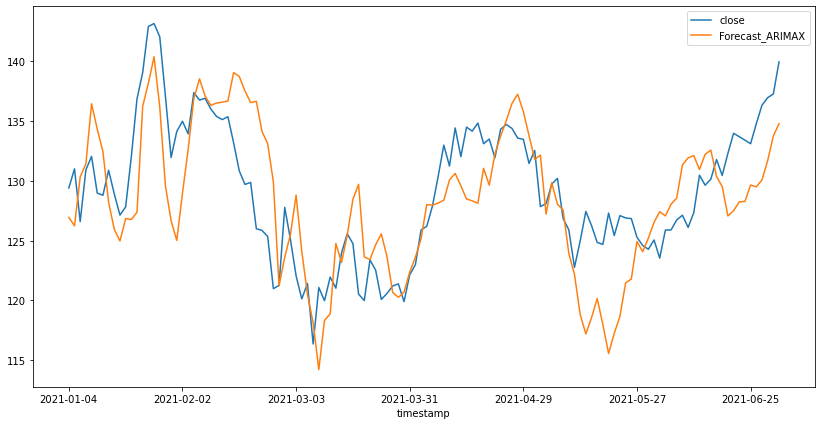

In [24]:
df_valid[["close", "Forecast_ARIMAX"]].plot(figsize=(14, 7))
#plot for timestamp>2020 only

In [25]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.close, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.close, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 4.545203101781902

MAE of Auto ARIMAX: 3.6031940472343527


In [26]:
mape = np.mean(np.abs(df_valid.Forecast_ARIMAX - df_valid.close)/np.abs(df_valid.close))
print('MAPE: '+str(mape*100) + ' %')

MAPE: 2.7890117210865037 %


In [27]:
mdape = np.median(np.abs(df_valid.Forecast_ARIMAX - df_valid.close)/np.abs(df_valid.close))
print('MDAPE: '+str(mdape*100) + ' %')

MDAPE: 2.5383303550604435 %


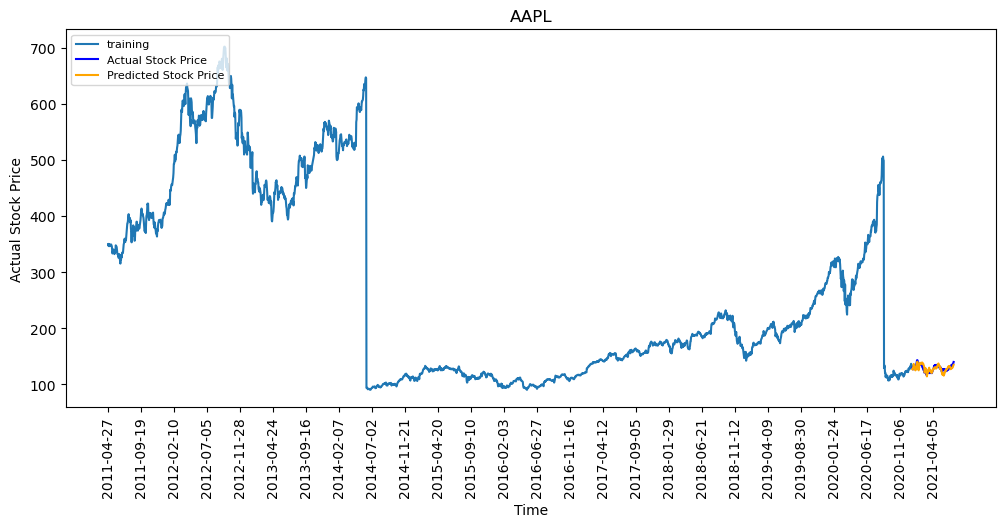

In [28]:
fc_series = pd.Series(df_valid.Forecast_ARIMAX, index=df_valid.index)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train['close'], label='training')
plt.plot(df_valid['close'], color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
plt.title(ticker)
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(np.arange(0,(len(df_train)+ len(df_valid)),100))
plt.xticks( rotation ='vertical')
plt.show()

The Auto ARIMAX model seems to do a fairly good job in predicting the stock price given data till the previous day. 

## Forecasting for the future
* to be completed